In [1]:
# !pip install transformers datasets evaluate accelerate

In [2]:
# !pip install kagglehub

In [3]:
# !conda install -c huggingface huggingface_hub

In [4]:
# !pip install tldextract

In [5]:
# !pip install nltk

In [6]:
from huggingface_hub import notebook_login
from huggingface_hub import HfFolder

notebook_login()

In [7]:
# Check if a token is saved
token = HfFolder.get_token()

if token:
    print("Logged in to Hugging Face.")
else:
    print("Not logged in to Hugging Face.")

Logged in to Hugging Face.


## Data Exploration

In [8]:
import kagglehub
import os
import pandas as pd
from sklearn.model_selection import train_test_split

path = kagglehub.dataset_download("gtkcyber/dga-dataset")
csv_path = os.path.join(path, 'dga_data.csv')
df = pd.read_csv(csv_path)

In [9]:
import tldextract

# df['tld'] = df['host'].str.split('.', n=1).str[1]
df['tld'] = df['host'].apply(lambda x: tldextract.extract(x).suffix)
df.sample(frac=1).head(10)

,isDGA,domain,host,subclass,tld
35189,dga,odoovbobquefiy,odoovbobquefiy.ru,cryptolocker,ru
135681,legit,realjewnews,realjewnews.com,legit,com
142272,legit,voyazteca,voyazteca.com,legit,com
159768,legit,hq,hq-sex-tube.com,alexa,com
125370,legit,echoecho,echoecho.com,alexa,com
99043,legit,dawgsbynature,dawgsbynature.com,alexa,com
102736,legit,fedexsameday,fedexsameday.com,legit,com
153703,legit,webstatico,webstatico.com,alexa,com
116677,legit,maerne,maerne.it,alexa,it
75163,dga,asubexkokglu,asubexkokglu.ru,cryptolocker,ru


In [10]:
df[df.isnull().any(axis=1)]

,isDGA,domain,host,subclass,tld
87182,legit,NaN,null.com,alexa,com
94473,legit,NaN,nan-net.com,alexa,com


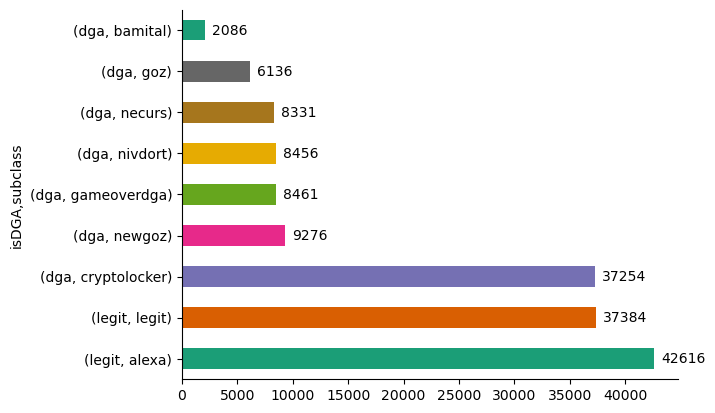

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns

# Plotting the grouped bar chart
counts = df.groupby(['isDGA', 'subclass']).size().sort_values(ascending=False)
ax = counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

# Adding value labels to each bar
for bar in ax.patches:
    ax.annotate(f'{int(bar.get_width())}',  # Convert count to integer and format as text
                (bar.get_width(), bar.get_y() + bar.get_height() / 2),  # Position at the end of each bar
                ha='left', va='center',  # Center alignment
                xytext=(5, 0),  # Offset text slightly for readability
                textcoords='offset points')  # Use offset points

# Display plot
plt.show()

The dataset is highly imbalanced. 

In [12]:
# Count unique TLDs for each subclass
unique_tld_counts = df.groupby(['subclass'])['tld'].nunique().sort_values(ascending=True)
df_dga = df.query("subclass != 'legit' and subclass != 'alexa'")
df_dga_tld = df_dga[['subclass', 'tld']].drop_duplicates().sort_values(by = 'subclass', ascending=True)
df_dga_tld = df_dga_tld.reset_index(drop=True)

print("Number of tld in subclass\n", unique_tld_counts)

Number of tld in subclass
 subclass
bamital           1
goz               1
nivdort           1
newgoz            4
gameoverdga       4
cryptolocker      7
necurs           43
legit           315
alexa           385
Name: tld, dtype: int64


In [13]:
pd.set_option('display.max_rows', None)
print(df_dga_tld)
pd.reset_option('display.max_rows')

        subclass    tld
0        bamital    org
1   cryptolocker    biz
2   cryptolocker     ru
3   cryptolocker    com
4   cryptolocker    net
5   cryptolocker   info
6   cryptolocker  co.uk
7   cryptolocker    org
8    gameoverdga    org
9    gameoverdga    com
10   gameoverdga    biz
11   gameoverdga    net
12           goz     ru
13        necurs     ga
14        necurs       
15        necurs     ac
16        necurs     ir
17        necurs     cm
18        necurs     bz
19        necurs     sx
20        necurs     co
21        necurs     nu
22        necurs     cx
23        necurs     ms
24        necurs     so
25        necurs     su
26        necurs     us
27        necurs     ki
28        necurs     kz
29        necurs     tv
30        necurs     me
31        necurs     mn
32        necurs    pro
33        necurs     ug
34        necurs     tw
35        necurs     mu
36        necurs    biz
37        necurs     cc
38        necurs     im
39        necurs     sc
40        necurs

Some findings: 
- gameoverdga and newgoz have the same set of tld 
- necurs has the most variations of tld

### Oversampling Method

In [14]:
sliced_df = df[['domain', 'host', 'subclass', 'tld']]
original_df = sliced_df.copy()

In [15]:
original_df['host'] = original_df['host'].fillna('')
original_df['domain'] = original_df['domain'].fillna('')

sliced_df['domain'] = sliced_df['domain'].fillna('')

/tmp/ipykernel_5608/2022476595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_df['domain'] = sliced_df['domain'].fillna('')


#### Data Augmentation

As seen from the subclass frequency, 6 of the 7 DGA subclasses are massively underrepresented. And since imbalanced dataset also hurts our model's learning

In [16]:
tld_to_append = {}

for subclass in sliced_df['subclass'].unique():
    curr_tld = sliced_df[sliced_df['subclass']== subclass]['tld'].unique().tolist()
    tld_to_append[subclass] = curr_tld
sliced_df = sliced_df.drop('tld', axis=1)

In [17]:
import random
import string

# Higher probabilities for more aggressive augmentations
augment_probs = {
    'swap': 0.4,
    'insert': 0.35,
    'delete': 0.3,
    'substitute': 0.25,
}

# Function to forcefully apply augmentations aggressively
def data_augment(domain, num_augmentations, tld_to_append):
    augmented_domains = set()

    while len(augmented_domains) < num_augmentations:
        augmented_domain = domain
        applied = False  # Track if any augmentation is applied

        # Loop through augmentations and apply each based on probability
        for _ in range(2):  # Apply 2 augmentations per call
            if random.random() < augment_probs['swap']:
                augmented_domain = swap_characters(augmented_domain)
                applied = True

            if random.random() < augment_probs['insert']:
                augmented_domain = insert_character(augmented_domain)
                applied = True

            if random.random() < augment_probs['delete']:
                augmented_domain = delete_character(augmented_domain)
                applied = True

            if random.random() < augment_probs['substitute']:
                augmented_domain = substitute_character(augmented_domain)
                applied = True

        # Ensure at least one augmentation is applied
        random_tld = random.choice(tld_to_append)
        augmented_domain_with_tld = f"{augmented_domain}.{random_tld}"

        augmented_domains.add((augmented_domain, augmented_domain_with_tld))
        # Add to set of unique augmented domains
    return list(augmented_domains)

# Define forced augmentation to ensure at least one augmentation
def force_random_augmentation(domain):
    aug_type = random.choice(['swap', 'insert', 'delete', 'substitute'])
    if aug_type == 'swap':
        return swap_characters(domain)
    elif aug_type == 'insert':
        return insert_character(domain)
    elif aug_type == 'delete':
        return delete_character(domain)
    elif aug_type == 'substitute':
        return substitute_character(domain)

# Swap adjacent characters in the domain
def swap_characters(domain):
    if len(domain) > 1:
        idx = random.randint(0, len(domain) - 2)
        domain_list = list(domain)
        domain_list[idx], domain_list[idx + 1] = domain_list[idx + 1], domain_list[idx]
        return ''.join(domain_list)
    return domain

# Insert a random character at a random position
def insert_character(domain):
    idx = random.randint(0, len(domain) - 1)
    random_char = random.choice(string.ascii_lowercase + string.digits)
    return domain[:idx] + random_char + domain[idx:]

# Delete a random character from the domain
def delete_character(domain):
    if len(domain) > 1:
        idx = random.randint(0, len(domain) - 1)
        return domain[:idx] + domain[idx + 1:]
    return domain

# Substitute a random character in the domain with another
def substitute_character(domain):
    idx = random.randint(0, len(domain) - 1)
    random_char = random.choice(string.ascii_lowercase + string.digits)
    return domain[:idx] + random_char + domain[idx + 1:]

In [18]:
target_subclasses = ['gameoverdga', 'newgoz', 'goz', 'necurs', 'bamital']

# Define the number of augmentations for each subclass
num_augmentations = {subclass: 4 for subclass in target_subclasses}
num_augmentations['bamital'] = 15

# Create a list to hold all new rows
new_rows = []

# Iterate through each subclass and apply data augmentation
for subclass in target_subclasses:
    domains_to_augment = sliced_df[sliced_df['subclass'] == subclass]['domain'].tolist()
    tld = tld_to_append[subclass]
    # Generate augmented domains using list comprehension
    augmented_domains = [
        (augmented_domain, augmented_host)
        for domain in domains_to_augment
        for augmented_domain, augmented_host in data_augment(domain, num_augmentations[subclass],tld)
    ]

    # Prepare new rows for the DataFrame
    new_rows.extend([{'domain': augmented_domain, 'host': augmented_host, 'subclass': subclass} for augmented_domain, augmented_host in augmented_domains])

# Convert the list of new rows to a DataFrame and append it to the original DataFrame
if new_rows:
    new_df = pd.DataFrame(new_rows)
    sliced_df = pd.concat([sliced_df, new_df], ignore_index=True)

In [19]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /home/ec2-user/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [20]:
import pandas as pd
from nltk.corpus import words

# Set of valid English words (for validation purposes)
word_set = set(words.words())

# Function to process all rows and store words in a dictionary
def extract_words_from_rows(df, column_name):
    word_dict = {}

    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        concatenated_word = row[column_name]
        word1, word2 = split_concatenated_words(concatenated_word,word_set)

        # Add the words to the dictionary and count their occurrences
        if word1 and word2:
            word_dict[word1] = word_dict.get(word1, 0) + 1
            word_dict[word2] = word_dict.get(word2, 0) + 1

    return word_dict

In [21]:
# prompt: using the word_dict, generate new nivdort domains that are not duplicate of the known ones (meaning if word 1 and word 2 is contained in a specific domain, we dont use that pair)
import random
import math

def split_concatenated_words(concatenated_word, word_set):
    """Splits a concatenated word into two valid words based on a word set."""
    for i in range(1, len(concatenated_word)):
        word1, word2 = concatenated_word[:i], concatenated_word[i:]
        if word1 in word_set and word2 in word_set:
            return word1, word2
    return concatenated_word, None

def generate_nivdort_domains(word_dict, known_domains, num_domains=32000, max_attempts=50, overlap_tolerance=0.1):
    """Generates new Nivdort domains with a balanced approach between uniqueness and aggression."""

    word_set = set(word_dict.keys())
    known_word_pairs = {frozenset([split_concatenated_words(domain.split('.')[0], word_set)]) for domain in known_domains}

    # Track newly generated domains and avoid strict overlap with known pairs
    new_domains = []
    i, j = 0, 0

    while i < num_domains and j < max_attempts * num_domains:
        word1 = random.choice(list(word_dict.keys()))
        word2 = random.choice(list(word_dict.keys()))

        # Check the pair uniqueness with some tolerance
        word_pair = frozenset([word1, word2])
        overlap = sum(1 for pair in known_word_pairs if pair == word_pair) / len(known_word_pairs)

        if overlap <= overlap_tolerance:  # Allow slight overlap with known pairs
            domain = word1 + word2

            if domain not in known_domains and domain not in new_domains:
                new_domains.append(domain)
                known_word_pairs.add(word_pair)  # Add to avoid duplicate generation
                i += 1
        j += 1

    return new_domains

In [22]:
known_nivdort_domains = df[df['subclass'] == 'nivdort']['domain'].tolist()
print(known_nivdort_domains)

['takenroll', 'dreamdont', 'visitshot', 'mostjune', 'fairslow', 'triedlady', 'movemarch', 'drinkusual', 'caseought', 'takenshoe', 'dreamfind', 'wifelate', 'gladtell', 'thesethan', 'dreamfine', 'madehear', 'wronghurry', 'knowpeace', 'casegreen', 'threethrow', 'hillgold', 'whichback', 'milkjune', 'quickcloth', 'wrongtear', 'darkthan', 'equalaugust', 'whichcompe', 'wrongoctober', 'songfloor', 'spendwhere', 'hangseven', 'drinkgrow', 'whichsuch', 'thenought', 'wishmarry', 'groupback', 'yardgift', 'dutywrote', 'joinaunt', 'joinrest', 'takenlift', 'caseborn', 'feltgold', 'triedking', 'milksaturday', 'rockhigh', 'takenprice', 'sickpast', 'lookdance', 'joinhope', 'feltboat', 'groupmoon', 'wronghunt', 'withfind', 'spotleft', 'movedish', 'fairunder', 'mademail', 'lordshade', 'equalhigh', 'spendheight', 'humanfind', 'wifemine', 'looksome', 'quickborn', 'arivepull', 'wishgold', 'watchslow', 'dutykind', 'wifepure', 'feltought', 'signhour', 'ariveover', 'songwrote', 'saltworld', 'wifehand', 'darkcons

In [23]:
word_dict = extract_words_from_rows(df[df['subclass'] == 'nivdort'], 'domain')
print(len(list(word_dict.keys())))

368


In [24]:
# Example usage:
new_nivdort_domains = generate_nivdort_domains(word_dict, known_nivdort_domains, num_domains=32000)
# print("New Nivdort Domains:", new_nivdort_domains)

In [25]:
# prompt: send these nivdort_domains to sliced_df
tld = tld_to_append['nivdort']

# Create new rows for the DataFrame
new_nivdort_rows = [{'host': f'{domain}.{random.choice(tld)}','domain': domain, 'subclass': 'nivdort'} for domain in new_nivdort_domains]

# Convert the list of new rows to a DataFrame and append it to the original DataFrame
if new_nivdort_rows:
    new_nivdort_df = pd.DataFrame(new_nivdort_rows)
    sliced_df = pd.concat([sliced_df, new_nivdort_df], ignore_index=True)

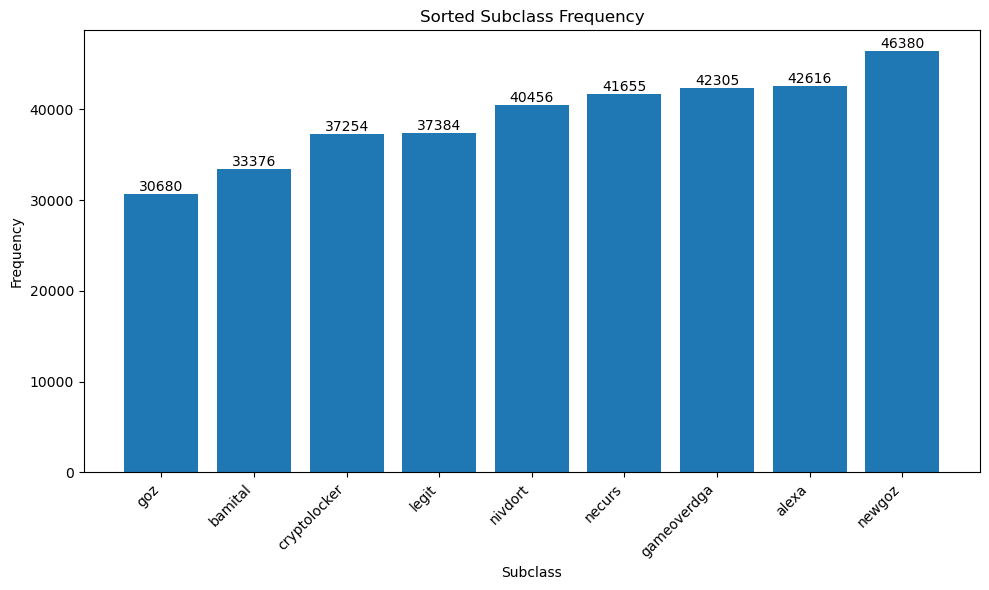

In [26]:
# prompt: visualize the sorted subclass frequency of sliced_df using vertical barchart with each frequency on the bar with 3 significant figures

# Assuming 'sliced_df' is your DataFrame
subclass_counts = sliced_df['subclass'].value_counts().sort_values()

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(subclass_counts.index, subclass_counts.values)

# Add frequency labels to the bars with 3 significant figures
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')

plt.xlabel('Subclass')
plt.ylabel('Frequency')
plt.title('Sorted Subclass Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Data Preparation

### Original Data

In [27]:
df.columns

Index(['isDGA', 'domain', 'host', 'subclass', 'tld'], dtype='object')

In [28]:
# Split the DataFrame 8:1:1 
df_rename = df.rename(columns={'host': 'text', 'subclass': 'label'})
y = df_rename['label']
df_train, df_temp = train_test_split(df_rename[['text', 'label']], test_size=0.2, stratify=y, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

# Create encoding dictionary
encoded_dict = {value: idx for idx, value in enumerate(df_rename['label'].unique())}

# Apply encoding and reset index for each split
for split_df in [df_train, df_val, df_test]:
    split_df['label'] = split_df['label'].map(encoded_dict)
    split_df.reset_index(drop=True, inplace=True)

In [29]:
df_train.columns

Index(['text', 'label'], dtype='object')

In [30]:
print(encoded_dict)

{'gameoverdga': 0, 'cryptolocker': 1, 'newgoz': 2, 'nivdort': 3, 'goz': 4, 'necurs': 5, 'bamital': 6, 'legit': 7, 'alexa': 8}


In [31]:
def subclass_mapping_back(df):
    df_copy = df.copy()
    df_copy['subclass_original'] = df_copy['label'].map({v: k for k, v in encoded_dict.items()})
    subclass_mapping_df = pd.DataFrame(list(encoded_dict.items()), columns=['subclass_original', 'encoded_subclass'])
    subclass_counts = df_copy['subclass_original'].value_counts().reset_index()
    subclass_counts.columns = ['subclass_original', 'count']
    result_df = subclass_counts.merge(subclass_mapping_df, on='subclass_original')
    result_df = result_df.sort_values(by='encoded_subclass').reset_index(drop=True)
    return result_df

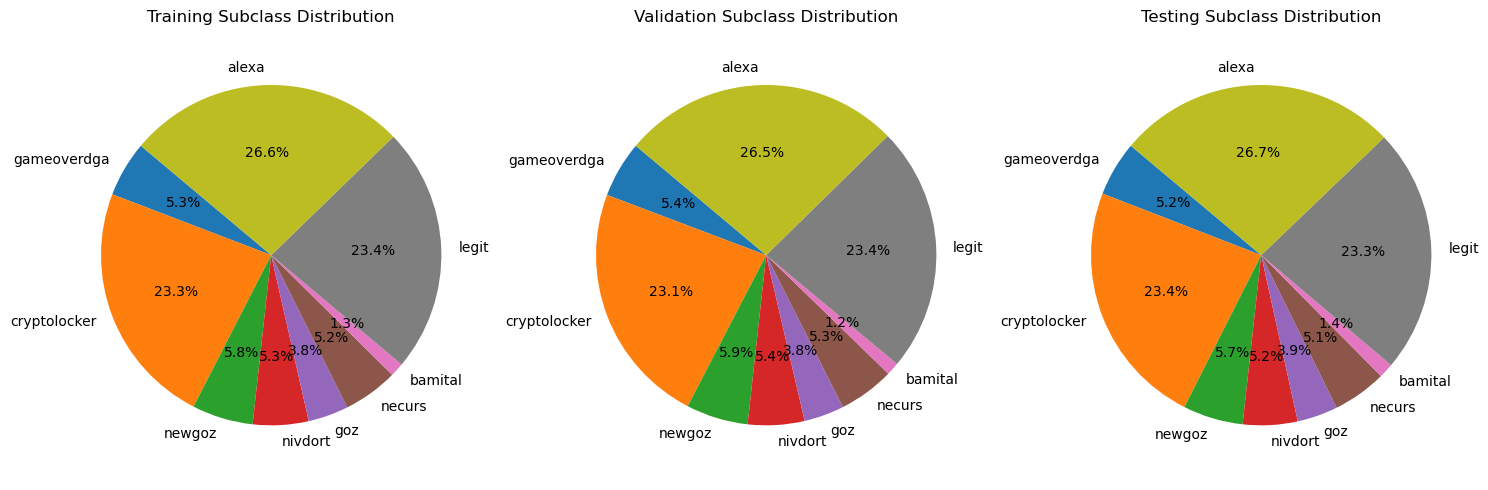

In [32]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create pie charts
axes[0].pie(subclass_mapping_back(df_train)['count'], labels=subclass_mapping_back(df_train)['subclass_original'], autopct='%1.1f%%', startangle=140)
axes[0].set_title('Training Subclass Distribution')
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

axes[1].pie(subclass_mapping_back(df_val)['count'], labels=subclass_mapping_back(df_val)['subclass_original'], autopct='%1.1f%%', startangle=140)
axes[1].set_title('Validation Subclass Distribution')
axes[1].axis('equal')

axes[2].pie(subclass_mapping_back(df_test)['count'], labels=subclass_mapping_back(df_test)['subclass_original'], autopct='%1.1f%%', startangle=140)
axes[2].set_title('Testing Subclass Distribution')
axes[2].axis('equal')

# Show the pie charts
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

The subclass distribution is preserved in training, validation, and testing. 

In [33]:
df_train.columns

Index(['text', 'label'], dtype='object')

In [34]:
from datasets import Dataset, DatasetDict

dga = DatasetDict()
dga['train'] = Dataset.from_pandas(df_train)
dga['validation'] = Dataset.from_pandas(df_val)
dga['test'] = Dataset.from_pandas(df_test)

In [35]:
dga

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 128000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

In [36]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [37]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [38]:
tokenized_dga = dga.map(preprocess_function, batched=True)

Map:   0%|          | 0/128000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

### Oversampled Data

In [39]:
print(sliced_df.shape)
sliced_df.head()

(352106, 3)


,domain,host,subclass
0,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,cryptolocker
2,xxmamopyipbfpk,xxmamopyipbfpk.ru,cryptolocker
3,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,jpqftymiuver,jpqftymiuver.ru,cryptolocker


In [40]:
# Split the DataFrame 8:1:1 
over_df_rename = sliced_df.rename(columns={'host': 'text', 'subclass': 'label'})
over_y = over_df_rename['label']
over_df_train, over_df_temp = train_test_split(over_df_rename[['text', 'label']], test_size=0.2, stratify=over_y, random_state=42)
over_df_val, over_df_test = train_test_split(over_df_temp, test_size=0.5, random_state=42)

# Create encoding dictionary
encoded_dict = {value: idx for idx, value in enumerate(over_df_rename['label'].unique())}

# Apply encoding and reset index for each split
for split_df in [over_df_train, over_df_val, over_df_test]:
    split_df['label'] = split_df['label'].map(encoded_dict)
    split_df.reset_index(drop=True, inplace=True)

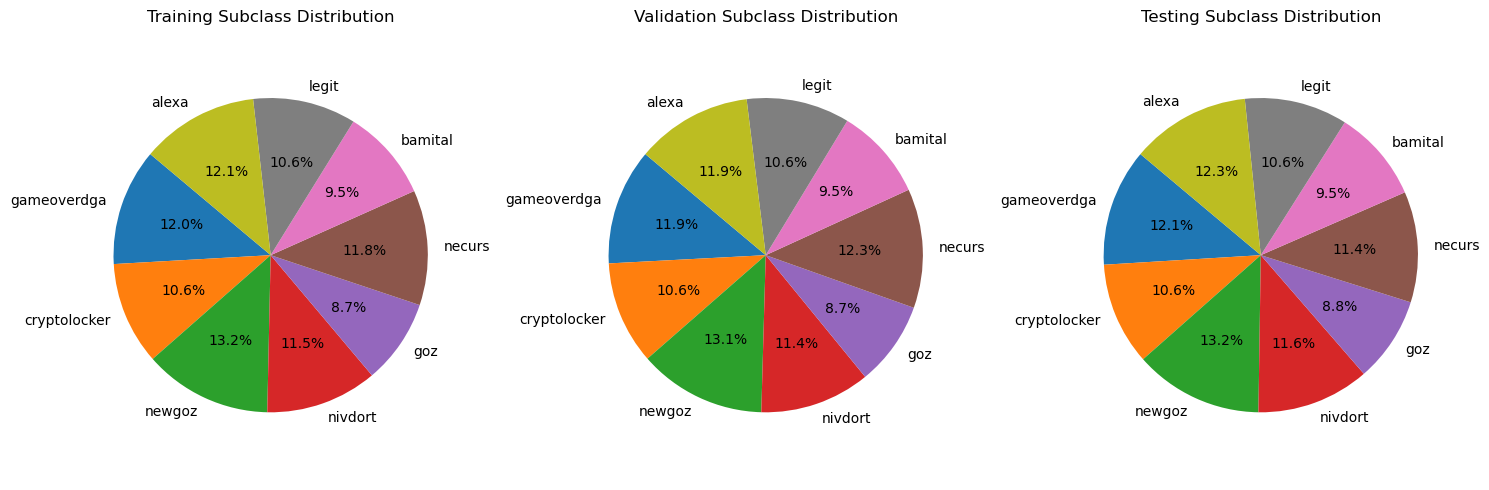

In [41]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create pie charts
axes[0].pie(subclass_mapping_back(over_df_train)['count'], labels=subclass_mapping_back(df_train)['subclass_original'], autopct='%1.1f%%', startangle=140)
axes[0].set_title('Training Subclass Distribution')
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

axes[1].pie(subclass_mapping_back(over_df_val)['count'], labels=subclass_mapping_back(df_val)['subclass_original'], autopct='%1.1f%%', startangle=140)
axes[1].set_title('Validation Subclass Distribution')
axes[1].axis('equal')

axes[2].pie(subclass_mapping_back(over_df_test)['count'], labels=subclass_mapping_back(df_test)['subclass_original'], autopct='%1.1f%%', startangle=140)
axes[2].set_title('Testing Subclass Distribution')
axes[2].axis('equal')

# Show the pie charts
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

The subclass is now more evenly distributed. 

In [42]:
over_dga = DatasetDict()
over_dga['train'] = Dataset.from_pandas(over_df_train)
over_dga['validation'] = Dataset.from_pandas(over_df_val)
over_dga['test'] = Dataset.from_pandas(over_df_test)

In [43]:
over_dga

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 281684
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 35211
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 35211
    })
})

In [44]:
tokenized_over_dga = over_dga.map(preprocess_function, batched=True)

Map:   0%|          | 0/281684 [00:00<?, ? examples/s]

Map:   0%|          | 0/35211 [00:00<?, ? examples/s]

Map:   0%|          | 0/35211 [00:00<?, ? examples/s]

In [45]:
tokenized_over_dga

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 281684
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 35211
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 35211
    })
})

## Model Building

In [46]:
!nvidia-smi

Sun Nov  3 04:11:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   18C    P8              8W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [47]:
import os

# Get current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

Current Directory: /home/ec2-user/SageMaker


In [48]:
import psutil

# Get the total, available, used, and percentage of RAM
memory_info = psutil.virtual_memory()
print(f"Total Memory: {memory_info.total / (1024**3):.2f} GB")
print(f"Available Memory: {memory_info.available / (1024**3):.2f} GB")
print(f"Used Memory: {memory_info.used / (1024**3):.2f} GB")
print(f"Memory Usage Percentage: {memory_info.percent}%")

Total Memory: 30.89 GB
Available Memory: 28.25 GB
Used Memory: 2.20 GB
Memory Usage Percentage: 8.5%


In [49]:
import shutil

# Check total, used, and free space on the root directory
total, used, free = shutil.disk_usage("/")

print("Total Disk Space: {:.2f} GB".format(total / (1024**3)))
print("Used Disk Space: {:.2f} GB".format(used / (1024**3)))
print("Free Disk Space: {:.2f} GB".format(free / (1024**3)))

Total Disk Space: 134.99 GB
Used Disk Space: 99.70 GB
Free Disk Space: 35.29 GB


### Original Data

In [50]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [51]:
import evaluate

accuracy = evaluate.load("accuracy")

In [52]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [53]:
label2id = encoded_dict
id2label = {v: k for k, v in label2id.items()}

In [54]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=9, id2label=id2label, label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
from transformers import TrainerCallback
import json

class SaveEpochMetricsCallback(TrainerCallback):
    def __init__(self, output_path="epoch_metrics.json"):
        # Initialize with a path to save epoch metrics
        self.output_path = output_path
        self.epoch_metrics = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Log the metrics at the end of each epoch
        metrics = {
            "epoch": state.epoch,
            "global_step": state.global_step,
            "train_loss": state.log_history[-1].get("loss", None),  # Last reported loss
            "eval_loss": state.log_history[-1].get("eval_loss", None),  # Last reported eval loss
        }
        self.epoch_metrics.append(metrics)

    def on_train_end(self, args, state, control, **kwargs):
        # Save metrics to JSON at the end of training
        with open(self.output_path, "w") as f:
            json.dump(self.epoch_metrics, f, indent=4)

In [56]:
import torch

# Clear the CUDA cache
torch.cuda.empty_cache()

In [59]:
training_args = TrainingArguments(
    output_dir="dga-classification",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=5,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="no",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dga["train"],
    eval_dataset=tokenized_dga["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[SaveEpochMetricsCallback(output_path="epoch_metrics.json")]
)

history = trainer.train()

/tmp/ipykernel_5608/3403474531.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.356100,0.476615,0.756125
2,0.364700,0.417080,0.767125
3,0.330700,0.447553,0.762437
4,0.295700,0.489753,0.756500
5,0.270800,0.515587,0.755563


In [60]:
trainer.push_to_hub()

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/victoriamgdln/dga-classification/commit/af4a7e8589637f1255113b97184dc60c91048906', commit_message='End of training', commit_description='', oid='af4a7e8589637f1255113b97184dc60c91048906', pr_url=None, repo_url=RepoUrl('https://huggingface.co/victoriamgdln/dga-classification', endpoint='https://huggingface.co', repo_type='model', repo_id='victoriamgdln/dga-classification'), pr_revision=None, pr_num=None)

In [61]:
log_history = trainer.state.log_history

In [62]:
log_history

[{'loss': 0.3737,
  'grad_norm': 2.1374993324279785,
  'learning_rate': 1.8e-05,
  'epoch': 0.5,
  'step': 500},
 {'loss': 0.3561,
  'grad_norm': 4.978313446044922,
  'learning_rate': 1.6000000000000003e-05,
  'epoch': 1.0,
  'step': 1000},
 {'eval_loss': 0.47661539912223816,
  'eval_accuracy': 0.756125,
  'eval_runtime': 27.8732,
  'eval_samples_per_second': 574.028,
  'eval_steps_per_second': 114.806,
  'epoch': 1.0,
  'step': 1000},
 {'loss': 0.3193,
  'grad_norm': 1.902908444404602,
  'learning_rate': 1.4e-05,
  'epoch': 1.5,
  'step': 1500},
 {'loss': 0.3647,
  'grad_norm': 3.0889077186584473,
  'learning_rate': 1.2e-05,
  'epoch': 2.0,
  'step': 2000},
 {'eval_loss': 0.41708001494407654,
  'eval_accuracy': 0.767125,
  'eval_runtime': 28.3376,
  'eval_samples_per_second': 564.621,
  'eval_steps_per_second': 112.924,
  'epoch': 2.0,
  'step': 2000},
 {'loss': 0.3252,
  'grad_norm': 4.5572590827941895,
  'learning_rate': 1e-05,
  'epoch': 2.5,
  'step': 2500},
 {'loss': 0.3307,
  'g

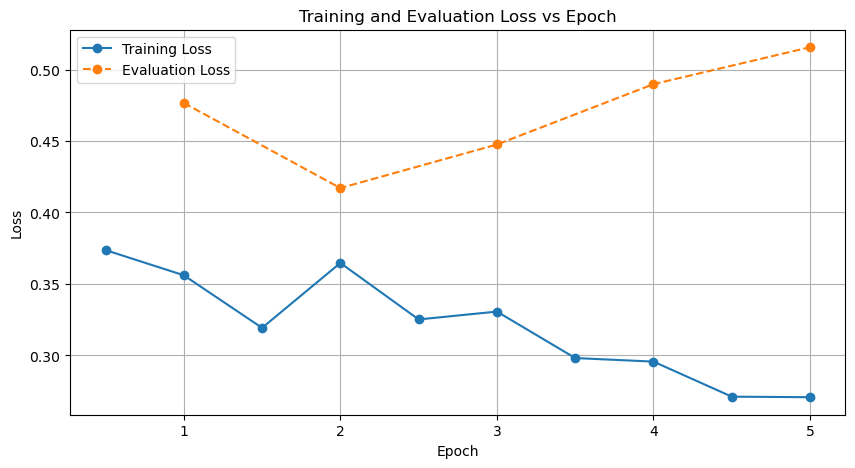

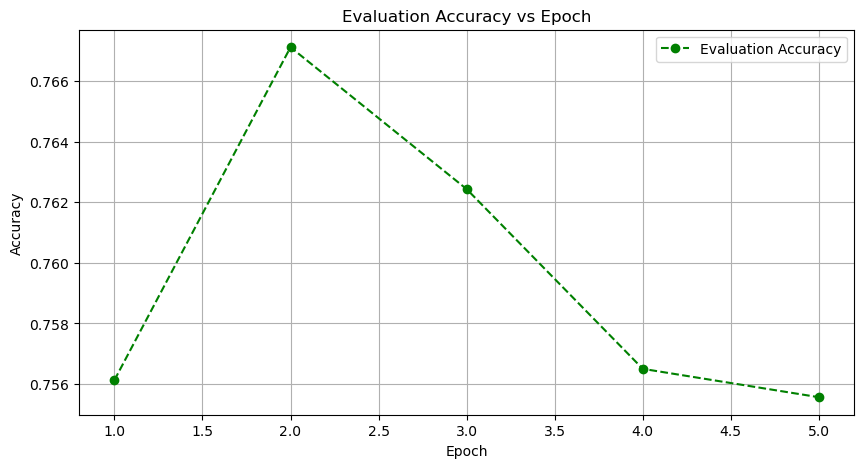

In [63]:
# Separate training and evaluation metrics
train_epochs, train_losses = [], []
eval_epochs, eval_losses, eval_accuracies = [], [], []

for entry in log_history:
    if 'loss' in entry and 'eval_loss' not in entry:  # Training loss
        train_epochs.append(entry['epoch'])
        train_losses.append(entry['loss'])
    elif 'eval_loss' in entry:  # Evaluation metrics
        eval_epochs.append(entry['epoch'])
        eval_losses.append(entry['eval_loss'])
        eval_accuracies.append(entry['eval_accuracy'])

# Plot Training and Evaluation Loss
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(train_epochs, train_losses, label='Training Loss', marker='o')

# Plot evaluation loss
plt.plot(eval_epochs, eval_losses, label='Evaluation Loss', marker='o', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot Evaluation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(eval_epochs, eval_accuracies, label='Evaluation Accuracy', marker='o', color='green', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

### Oversampled Data

In [64]:
training_args_oversampling = TrainingArguments(
    output_dir="dga-classification-oversampling",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=5,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="no",
    push_to_hub=True,
)

trainer_oversampling = Trainer(
    model=model,
    args=training_args_oversampling,
    train_dataset=tokenized_over_dga["train"],
    eval_dataset=tokenized_over_dga["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[SaveEpochMetricsCallback(output_path="epoch_oversampling_metrics.json")]
)

history_oversampling = trainer_oversampling.train()

/tmp/ipykernel_5608/676670292.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_oversampling = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.314200,0.331866,0.797336
2,0.282900,0.335600,0.798046
3,0.253700,0.377107,0.806225
4,0.233800,0.396916,0.809662
5,0.218700,0.432980,0.812104


In [65]:
trainer_oversampling.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/victoriamgdln/dga-classification-oversampling/commit/574991135bd9934440de2b99db59e18cf40cb1af', commit_message='End of training', commit_description='', oid='574991135bd9934440de2b99db59e18cf40cb1af', pr_url=None, repo_url=RepoUrl('https://huggingface.co/victoriamgdln/dga-classification-oversampling', endpoint='https://huggingface.co', repo_type='model', repo_id='victoriamgdln/dga-classification-oversampling'), pr_revision=None, pr_num=None)

In [66]:
log_history_oversampling = trainer_oversampling.state.log_history

In [67]:
log_history_oversampling

[{'loss': 0.3249,
  'grad_norm': 4.779788970947266,
  'learning_rate': 1.9091322126306227e-05,
  'epoch': 0.22716946842344388,
  'step': 500},
 {'loss': 0.3138,
  'grad_norm': 3.232457399368286,
  'learning_rate': 1.818264425261245e-05,
  'epoch': 0.45433893684688775,
  'step': 1000},
 {'loss': 0.3144,
  'grad_norm': 3.175779104232788,
  'learning_rate': 1.7273966378918672e-05,
  'epoch': 0.6815084052703316,
  'step': 1500},
 {'loss': 0.3142,
  'grad_norm': 2.3754074573516846,
  'learning_rate': 1.6365288505224898e-05,
  'epoch': 0.9086778736937755,
  'step': 2000},
 {'eval_loss': 0.3318658173084259,
  'eval_accuracy': 0.7973360597540541,
  'eval_runtime': 68.1528,
  'eval_samples_per_second': 516.648,
  'eval_steps_per_second': 103.341,
  'epoch': 1.0,
  'step': 2201},
 {'loss': 0.2899,
  'grad_norm': 2.696373462677002,
  'learning_rate': 1.5456610631531124e-05,
  'epoch': 1.1358473421172195,
  'step': 2500},
 {'loss': 0.2817,
  'grad_norm': 6.105727195739746,
  'learning_rate': 1.454

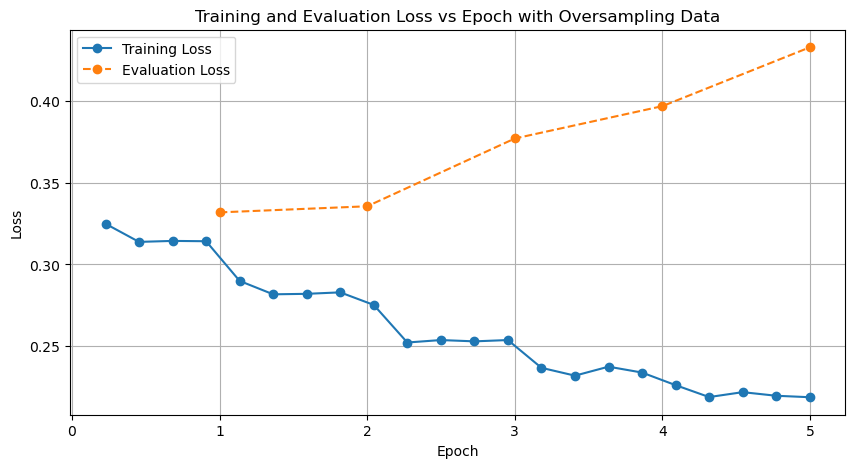

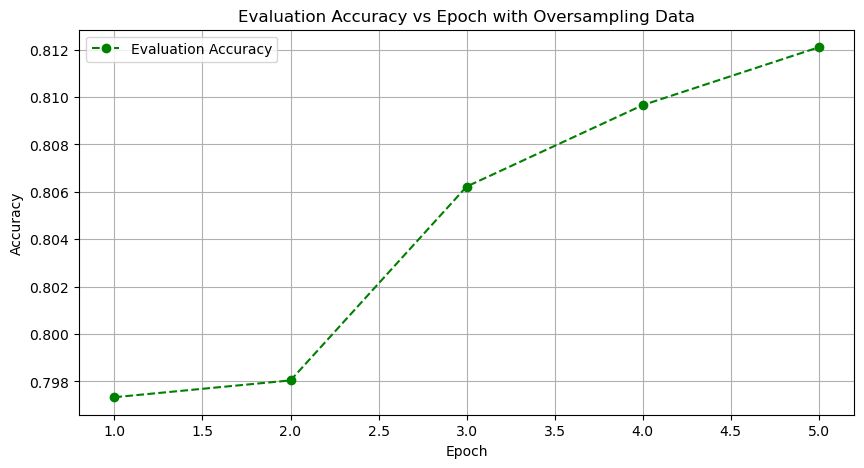

In [68]:
# Separate training and evaluation metrics
over_train_epochs, over_train_losses = [], []
over_eval_epochs, over_eval_losses, over_eval_accuracies = [], [], []

for entry in log_history_oversampling:
    if 'loss' in entry and 'eval_loss' not in entry:  # Training loss
        over_train_epochs.append(entry['epoch'])
        over_train_losses.append(entry['loss'])
    elif 'eval_loss' in entry:  # Evaluation metrics
        over_eval_epochs.append(entry['epoch'])
        over_eval_losses.append(entry['eval_loss'])
        over_eval_accuracies.append(entry['eval_accuracy'])

# Plot Training and Evaluation Loss
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(over_train_epochs, over_train_losses, label='Training Loss', marker='o')

# Plot evaluation loss
plt.plot(over_eval_epochs, over_eval_losses, label='Evaluation Loss', marker='o', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss vs Epoch with Oversampling Data')
plt.legend()
plt.grid(True)
plt.show()

# Plot Evaluation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(over_eval_epochs, over_eval_accuracies, label='Evaluation Accuracy', marker='o', color='green', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy vs Epoch with Oversampling Data')
plt.legend()
plt.grid(True)
plt.show()

### Original vs Oversampling Data Performance  

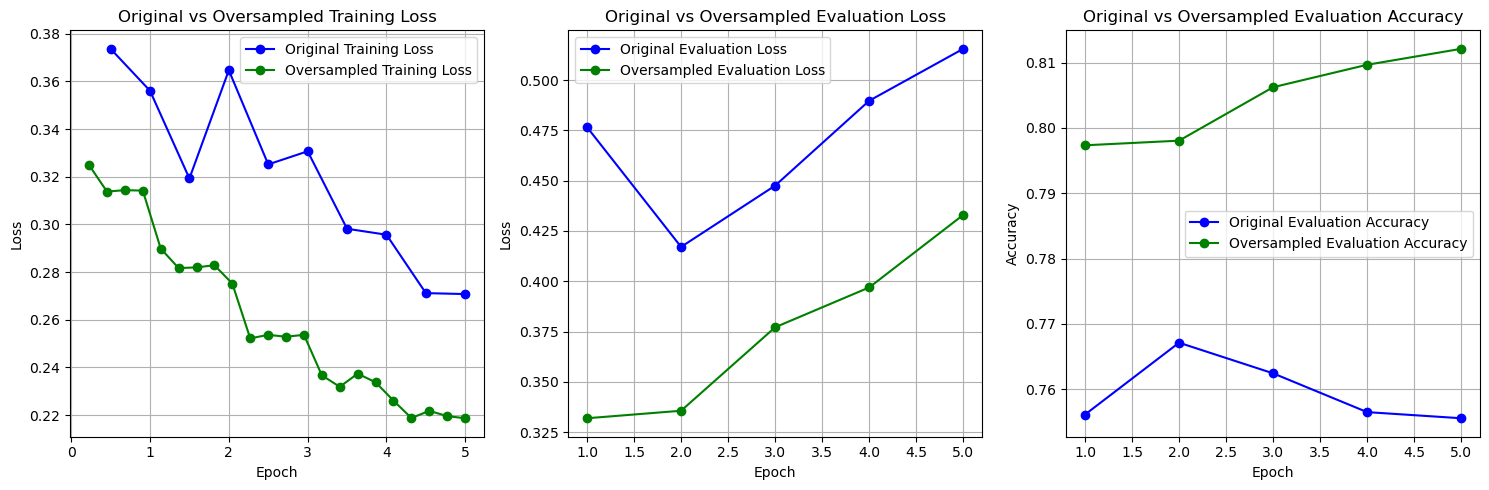

In [70]:
# Set up a 1x2 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(train_epochs, train_losses, label='Original Training Loss', marker='o', color='blue')
axes[0].plot(over_train_epochs, over_train_losses, label='Oversampled Training Loss', marker='o', color='green')
axes[0].set_title("Original vs Oversampled Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(eval_epochs, eval_losses, label='Original Evaluation Loss', marker='o', color='blue')
axes[1].plot(over_eval_epochs, over_eval_losses, label='Oversampled Evaluation Loss', marker='o', color='green')
axes[1].set_title("Original vs Oversampled Evaluation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(eval_epochs, eval_accuracies, label='Original Evaluation Accuracy', marker='o', color='blue')
axes[2].plot(over_eval_epochs, over_eval_accuracies, label='Oversampled Evaluation Accuracy', marker='o', color='green')
axes[2].set_title("Original vs Oversampled Evaluation Accuracy")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Accuracy")
axes[2].legend()
axes[2].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## Model Evaluation

In [71]:
from transformers import pipeline

classifier = pipeline("text-classification", model="victoriamgdln/dga-classification", device='cuda:0', batch_size=8)
classifier_oversampled = pipeline("text-classification", model="victoriamgdln/dga-classification-oversampling", device='cuda:0', batch_size=8)

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [72]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [73]:
isDGA_dict = {}
for subclass in encoded_dict:
    if subclass == 'legit' or subclass == 'alexa':
        isDGA_dict[subclass] = 'Legit'
    else: 
        isDGA_dict[subclass] = 'DGA'
isDGA_dict

{'gameoverdga': 'DGA',
 'cryptolocker': 'DGA',
 'newgoz': 'DGA',
 'nivdort': 'DGA',
 'goz': 'DGA',
 'necurs': 'DGA',
 'bamital': 'DGA',
 'legit': 'Legit',
 'alexa': 'Legit'}

In [74]:
def map_dict_to_binary(predicted): 
    return [isDGA_dict[item['label']] for item in predicted]

def map_list_to_binary(true): 
    return [isDGA_dict[item] for item in true]

def map_to_id(array):
    return [label2id[item] for item in array]

### Original

In [75]:
# Train
train_text = dga['train']['text']
train_predicted_raw = classifier(train_text)
y_train_predicted = [item['label'] for item in train_predicted_raw]

train_label = dga['train']['label']
y_train_true = [id2label[label] for label in train_label]

In [76]:
# Validation
val_text = dga['validation']['text']
val_predicted_raw = classifier(val_text)
y_val_predicted = [item['label'] for item in val_predicted_raw]

val_label = dga['validation']['label']
y_val_true = [id2label[label] for label in val_label]

In [77]:
# Test
test_text = dga['test']['text']
test_predicted_raw = classifier(test_text)
y_test_predicted = [item['label'] for item in test_predicted_raw]

test_label = dga['test']['label']
y_test_true = [id2label[label] for label in test_label]

In [78]:
y_binary_train_predicted = map_dict_to_binary(train_predicted_raw)
y_binary_train_true = map_list_to_binary(y_train_true)

y_binary_val_predicted = map_dict_to_binary(val_predicted_raw)
y_binary_val_true = map_list_to_binary(y_val_true)

y_binary_test_predicted = map_dict_to_binary(test_predicted_raw)
y_binary_test_true = map_list_to_binary(y_test_true)

### Oversampled

In [79]:
# Train
over_train_text = over_dga['train']['text']
over_train_predicted_raw = classifier_oversampled(over_train_text)
y_over_train_predicted = [item['label'] for item in over_train_predicted_raw]

over_train_label = over_dga['train']['label']
y_over_train_true = [id2label[label] for label in over_train_label]

In [80]:
# Validation
over_val_text = over_dga['validation']['text']
over_val_predicted_raw = classifier_oversampled(over_val_text)
y_over_val_predicted = [item['label'] for item in over_val_predicted_raw]

over_val_label = over_dga['validation']['label']
y_over_val_true = [id2label[label] for label in over_val_label]

In [81]:
# Test
over_test_text = over_dga['test']['text']
over_test_predicted_raw = classifier_oversampled(over_test_text)
y_over_test_predicted = [item['label'] for item in over_test_predicted_raw]

over_test_label = over_dga['test']['label']
y_over_test_true = [id2label[label] for label in over_test_label]

In [82]:
y_binary_over_train_predicted = map_dict_to_binary(over_train_predicted_raw) 
y_binary_over_train_true = map_list_to_binary(y_over_train_true)

y_binary_over_val_predicted = map_dict_to_binary(over_val_predicted_raw) 
y_binary_over_val_true = map_list_to_binary(y_over_val_true)

y_binary_over_test_predicted = map_dict_to_binary(over_test_predicted_raw) 
y_binary_over_test_true = map_list_to_binary(y_over_test_true)

### Classification Report

In [83]:
train_report = classification_report(y_train_true, y_train_predicted)
val_report = classification_report(y_val_true, y_val_predicted)
test_report = classification_report(y_test_true, y_test_predicted)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [85]:
print("Original Train Classification Report\n", train_report)
print("Original Validation Classification Report\n", val_report)
print("Original Test Classification Report\n", test_report)

Original Train Classification Report
               precision    recall  f1-score   support

       alexa       0.89      0.92      0.90     34092
     bamital       1.00      1.00      1.00      1669
cryptolocker       0.99      1.00      1.00     29803
 gameoverdga       0.86      0.00      0.00      6769
         goz       1.00      1.00      1.00      4909
       legit       0.90      0.87      0.88     29907
      necurs       1.00      0.97      0.99      6665
      newgoz       0.52      1.00      0.69      7421
     nivdort       1.00      1.00      1.00      6765

    accuracy                           0.89    128000
   macro avg       0.91      0.86      0.83    128000
weighted avg       0.91      0.89      0.87    128000

Original Validation Classification Report
               precision    recall  f1-score   support

       alexa       0.64      0.69      0.66      4247
     bamital       0.99      1.00      1.00       195
cryptolocker       0.99      1.00      0.99      37

In [84]:
over_train_report = classification_report(y_over_train_true, y_over_train_predicted)
over_val_report = classification_report(y_over_val_true, y_over_val_predicted)
over_test_report = classification_report(y_over_test_true, y_over_test_predicted)

In [86]:
# Oversampled model test against oversampled data 
print("Train Classification Report with Oversampling\n", over_train_report)
print("Validation Classification Report with Oversampling\n", over_val_report)
print("Test Classification Report with Oversampling\n", over_test_report)

Train Classification Report with Oversampling
               precision    recall  f1-score   support

       alexa       0.98      0.99      0.98     34092
     bamital       1.00      1.00      1.00     26701
cryptolocker       0.98      1.00      0.99     29803
 gameoverdga       0.54      0.52      0.53     33844
         goz       1.00      1.00      1.00     24544
       legit       0.99      0.98      0.98     29907
      necurs       1.00      0.98      0.99     33324
      newgoz       0.57      0.59      0.58     37104
     nivdort       1.00      1.00      1.00     32365

    accuracy                           0.88    281684
   macro avg       0.89      0.89      0.89    281684
weighted avg       0.88      0.88      0.88    281684

Validation Classification Report with Oversampling
               precision    recall  f1-score   support

       alexa       0.74      0.67      0.70      4206
     bamital       1.00      1.00      1.00      3339
cryptolocker       0.97      0.99

### ROC-AUC Score

In [87]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
def compute_roc_auc(y_true, y_predicted): 
    true_one_hot = encoder.fit_transform(np.array(map_to_id(y_true)).reshape(-1, 1))
    predicted_one_hot = encoder.transform(np.array(map_to_id(y_predicted)).reshape(-1, 1))
    result = roc_auc_score(true_one_hot, predicted_one_hot, average="macro", multi_class="ovo")
    return result

train_roc_auc = compute_roc_auc(y_train_true, y_train_predicted)
val_roc_auc = compute_roc_auc(y_val_true, y_val_predicted)
test_roc_auc = compute_roc_auc(y_test_true, y_test_predicted)

print('Original Train ROC-AUC Score:', train_roc_auc)
print('Original Validation ROC-AUC Score:', val_roc_auc)
print('Original Test ROC-AUC Score:', test_roc_auc)

Original Train ROC-AUC Score: 0.923568032120667
Original Validation ROC-AUC Score: 0.8808546022540473
Original Test ROC-AUC Score: 0.879295305468593


In [88]:
over_train_roc_auc = compute_roc_auc(y_over_train_true, y_over_train_predicted)
over_val_roc_auc = compute_roc_auc(y_over_val_true, y_over_val_predicted)
over_test_roc_auc = compute_roc_auc(y_over_test_true, y_over_test_predicted)

print('Oversampled Train ROC-AUC Score:', over_train_roc_auc)
print('Oversampled Validation ROC-AUC Score:', over_val_roc_auc)
print('Oversampled Test ROC-AUC Score:', over_test_roc_auc)

Oversampled Train ROC-AUC Score: 0.9397255440863082
Oversampled Validation ROC-AUC Score: 0.9013773752741027
Oversampled Test ROC-AUC Score: 0.9006728895521705


### Confusion Matrix

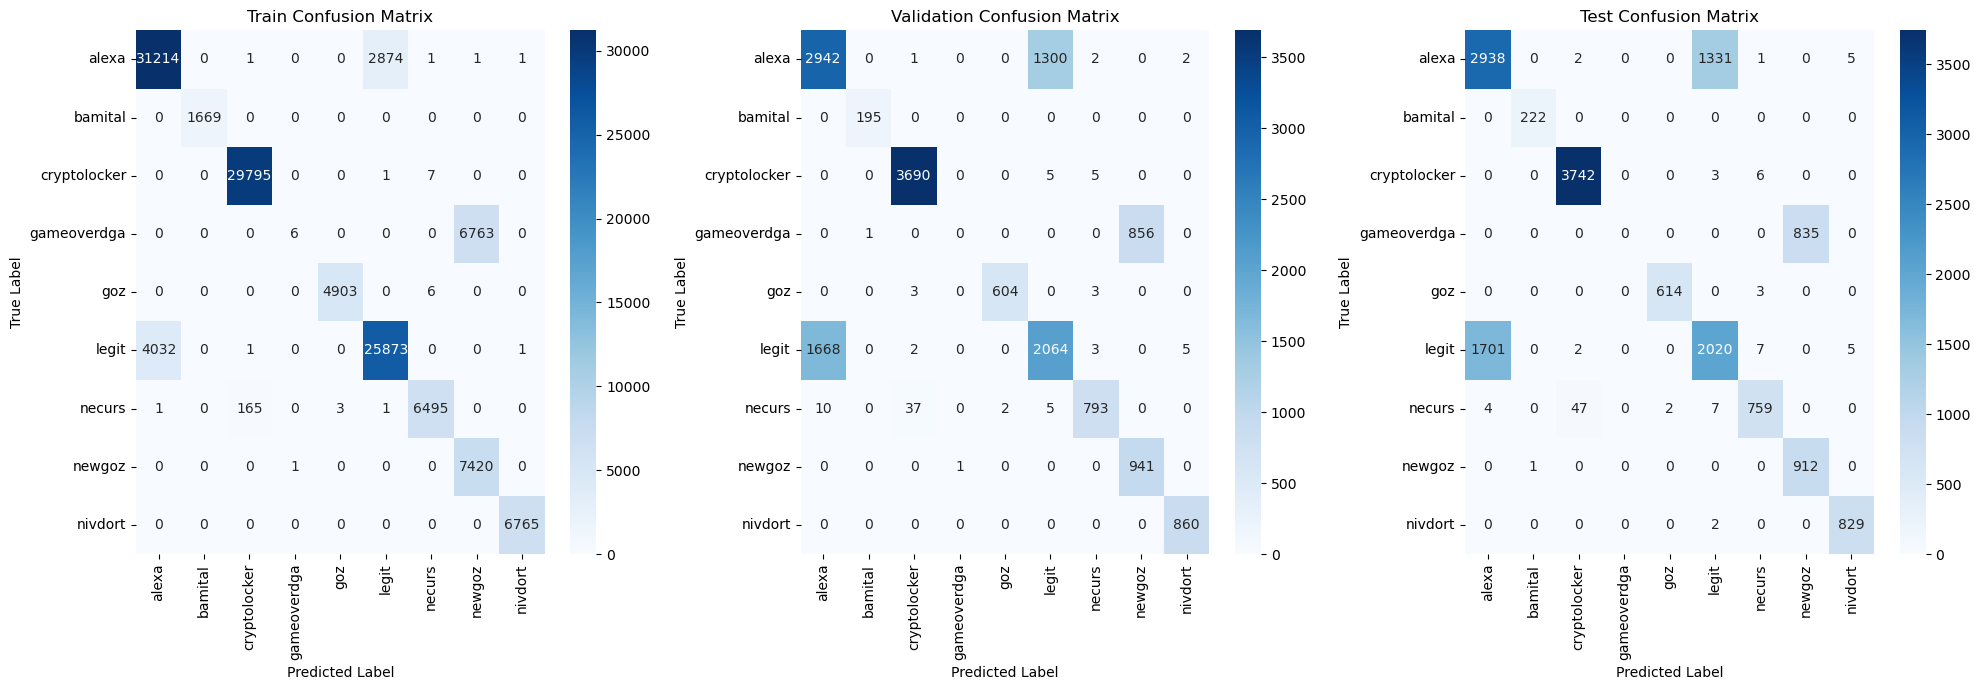

In [89]:
def generate_confusion_matrix(y_true, y_predicted, ax, type):
    conf_matrix = confusion_matrix(y_true, y_predicted)

    # Plot the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title(f'{type} Confusion Matrix')

    
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))  # 1 row, 3 columns

# Generate confusion matrices
generate_confusion_matrix(y_train_true, y_train_predicted, axes[0], 'Train')
generate_confusion_matrix(y_val_true, y_val_predicted, axes[1], 'Validation')
generate_confusion_matrix(y_test_true, y_test_predicted, axes[2], 'Test')

# Adjust layout
plt.tight_layout()
plt.show()

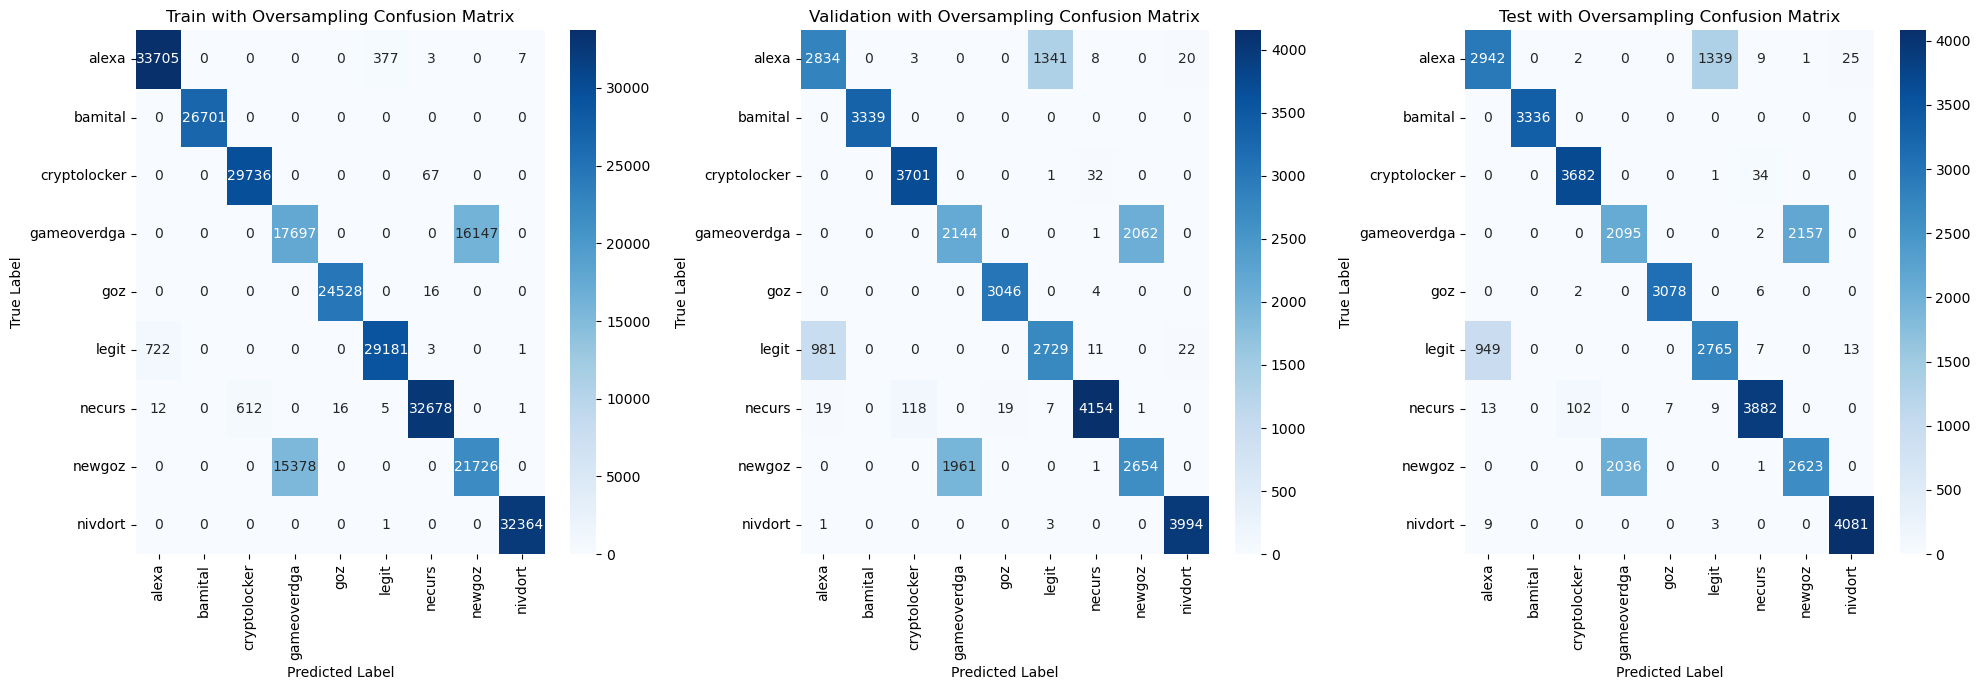

In [92]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))  # 1 row, 3 columns

# Generate confusion matrices
generate_confusion_matrix(y_over_train_true, y_over_train_predicted, axes[0], 'Train with Oversampling')
generate_confusion_matrix(y_over_val_true, y_over_val_predicted, axes[1], 'Validation with Oversampling')
generate_confusion_matrix(y_over_test_true, y_over_test_predicted, axes[2], 'Test with Oversampling')

# Adjust layout
plt.tight_layout()
plt.show()

### Binary Classification

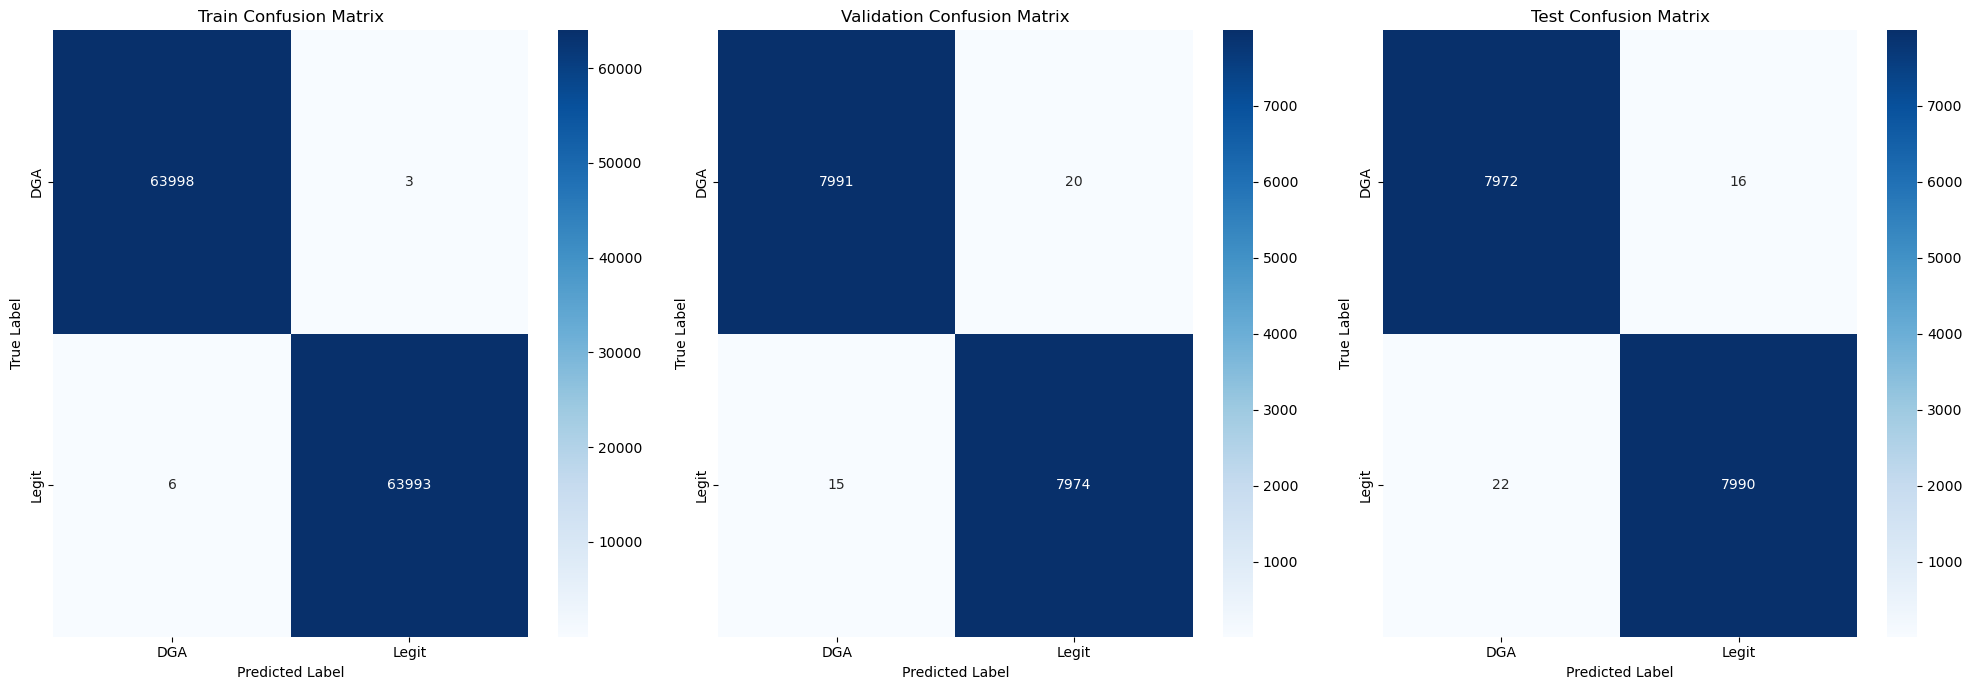

In [93]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))  # 1 row, 3 columns

# Generate confusion matrices
generate_confusion_matrix(y_binary_train_true, y_binary_train_predicted, axes[0], 'Train')
generate_confusion_matrix(y_binary_val_true, y_binary_val_predicted, axes[1], 'Validation')
generate_confusion_matrix(y_binary_test_true, y_binary_test_predicted, axes[2], 'Test')

# Adjust layout
plt.tight_layout()
plt.show()

In [131]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_binary_test_true_encoded = le.fit_transform(y_binary_test_true)
y_binary_test_predicted_encoded = le.transform(y_binary_test_predicted)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy: ', f"{accuracy_score(y_binary_test_true, y_binary_test_predicted) * 100:.3f}%")
print('Precision Score: ', f"{precision_score(y_binary_test_true_encoded, y_binary_test_predicted_encoded) * 100:.3f}%")
print('Recall Score: ', f"{recall_score(y_binary_test_true_encoded, y_binary_test_predicted_encoded) * 100:.3f}%")
print('F1 Score: ', f"{f1_score(y_binary_test_true_encoded, y_binary_test_predicted_encoded) * 100:.3f}%")

Accuracy:  99.763%
Precision Score:  99.800%
Recall Score:  99.725%
F1 Score:  99.763%


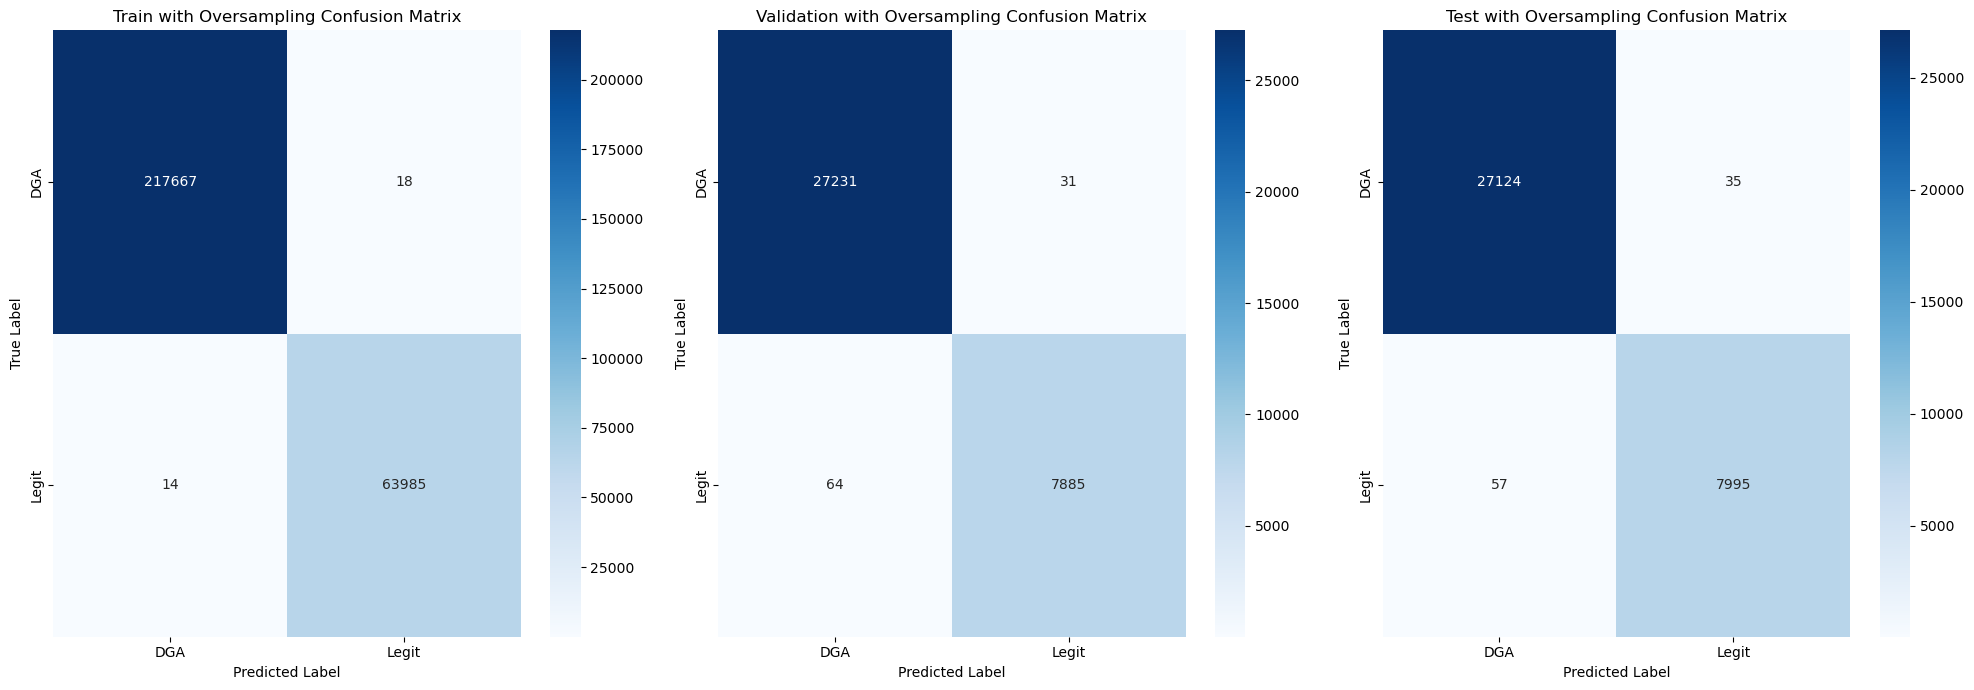

In [95]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))  # 1 row, 3 columns

# Generate confusion matrices
generate_confusion_matrix(y_binary_over_train_true, y_binary_over_train_predicted, axes[0], 'Train with Oversampling')
generate_confusion_matrix(y_binary_over_val_true, y_binary_over_val_predicted, axes[1], 'Validation with Oversampling')
generate_confusion_matrix(y_binary_over_test_true, y_binary_over_test_predicted, axes[2], 'Test with Oversampling')

# Adjust layout
plt.tight_layout()
plt.show()

In [133]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_binary_over_test_true_encoded = le.fit_transform(y_binary_over_test_true)
y_binary_over_test_predicted_encoded = le.transform(y_binary_over_test_predicted)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy: ', f"{accuracy_score(y_binary_over_test_true, y_binary_over_test_predicted) * 100:.3f}%")
print('Precision Score: ', f"{precision_score(y_binary_over_test_true_encoded, y_binary_over_test_predicted_encoded) * 100:.3f}%")
print('Recall Score: ', f"{recall_score(y_binary_over_test_true_encoded, y_binary_over_test_predicted_encoded) * 100:.3f}%")
print('F1 Score: ', f"{f1_score(y_binary_over_test_true_encoded, y_binary_over_test_predicted_encoded) * 100:.3f}%")

Accuracy:  99.739%
Precision Score:  99.564%
Recall Score:  99.292%
F1 Score:  99.428%
